# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


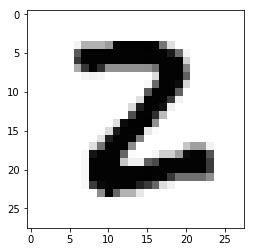

In [3]:
plt.imshow(mnist.train.images[76].reshape(28,28),cmap='Greys')

## The Generator

In [4]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
    

## The Discriminator

In [5]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [6]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [7]:
G = generator(z,reuse=tf.AUTO_REUSE)

### Discriminator 

In [8]:
D_output_real , D_logits_real = discriminator(real_images,reuse=tf.AUTO_REUSE)

In [9]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Losses

In [10]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [11]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real))

In [12]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss**2

In [14]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [18]:
batch_size = 100
epochs = 500
saver = tf.train.Saver()

In [19]:
# Save a sample per epoch
samples = []

with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        
        saver.save(sess, './models/500_epoch_model.ckpt')

In [20]:
img = tf.placeholder(tf.float32, shape=(1, 784))

In [21]:
mask = np.ones(shape=[28,28], dtype=np.float32)
mask[10:15,10:15] = 0
mask = mask.reshape(1,784)

In [22]:
img_to_correct = tf.multiply(tf.reshape(img, shape=(28,28)), tf.convert_to_tensor(tf.reshape(mask, shape=(28,28))))

In [23]:
zhat = tf.Variable(initial_value = np.random.uniform(-1, 1, size=(1, 100)).astype("float32"), dtype=tf.float32)

In [24]:
G1=generator(zhat,reuse=tf.AUTO_REUSE)

In [25]:
img_gen_masked = tf.multiply(tf.reshape(G1, shape=(28,28)), tf.convert_to_tensor(tf.reshape(mask, shape=(28,28))))

In [26]:
contextual_loss = tf.reduce_sum(tf.abs(img_gen_masked - img_to_correct))

In [27]:
# perceptual_loss = G_loss
perceptual_loss=(1- discriminator(G1,reuse=True)[0])

In [28]:
complete_loss = 12**contextual_loss + perceptual_loss**14

In [29]:
complete_loss_trainer = tf.train.AdamOptimizer(learning_rate).minimize(complete_loss,var_list=zhat)

In [30]:
init = tf.global_variables_initializer()

import numpy as np
from sklearn.preprocessing import normalize

x = np.random.rand(100)*10

norm = normalize(x[:,np.newaxis], axis=0).ravel()

print(x)
print('\n')
print(norm)

### Actual Image

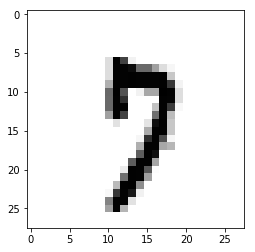

In [31]:
plt.imshow(mnist.train.images[25].reshape(28,28),cmap='Greys')

### Applying model

In [32]:
# from sklearn.preprocessing import normalize
# saver = tf.train.Saver()
v = 0
new_samples = []
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,'./models1/500_epoch_model.ckpt')
    
    
    for x in range(1000):
        run = [complete_loss_trainer,zhat]
        _,yeeee = sess.run(run, feed_dict = {img: mnist.train.images[25].reshape(1, 784)})
        
    image_generated=sess.run(generator(zhat,reuse=True),feed_dict={zhat:yeeee})
#         zhat = normalize(zhat[:], axis=1).ravel()
#         zhat = zhat.reshape(1, 100)
#         zhat = np.clip(zhat, -1, 1)

INFO:tensorflow:Restoring parameters from ./models1/500_epoch_model.ckpt


C:\Users\simra\Anaconda3\lib\site-packages\matplotlib\colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\simra\Anaconda3\lib\site-packages\numpy\ma\core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


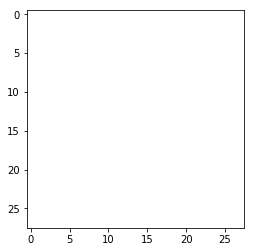

In [33]:
plt.imshow(image_generated.reshape(28,28),cmap='Greys')